In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


/Users/lefebvreremy/miniconda3/envs/env-prophet/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Load prepared dataset
df = pd.read_csv("../prepared_data/01_06_2021_to_20_06_2023_anais.csv", parse_dates=[0], index_col=[0])

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) /y_true)) * 100

<Axes: title={'center': 'ENTRIES'}, xlabel='date'>

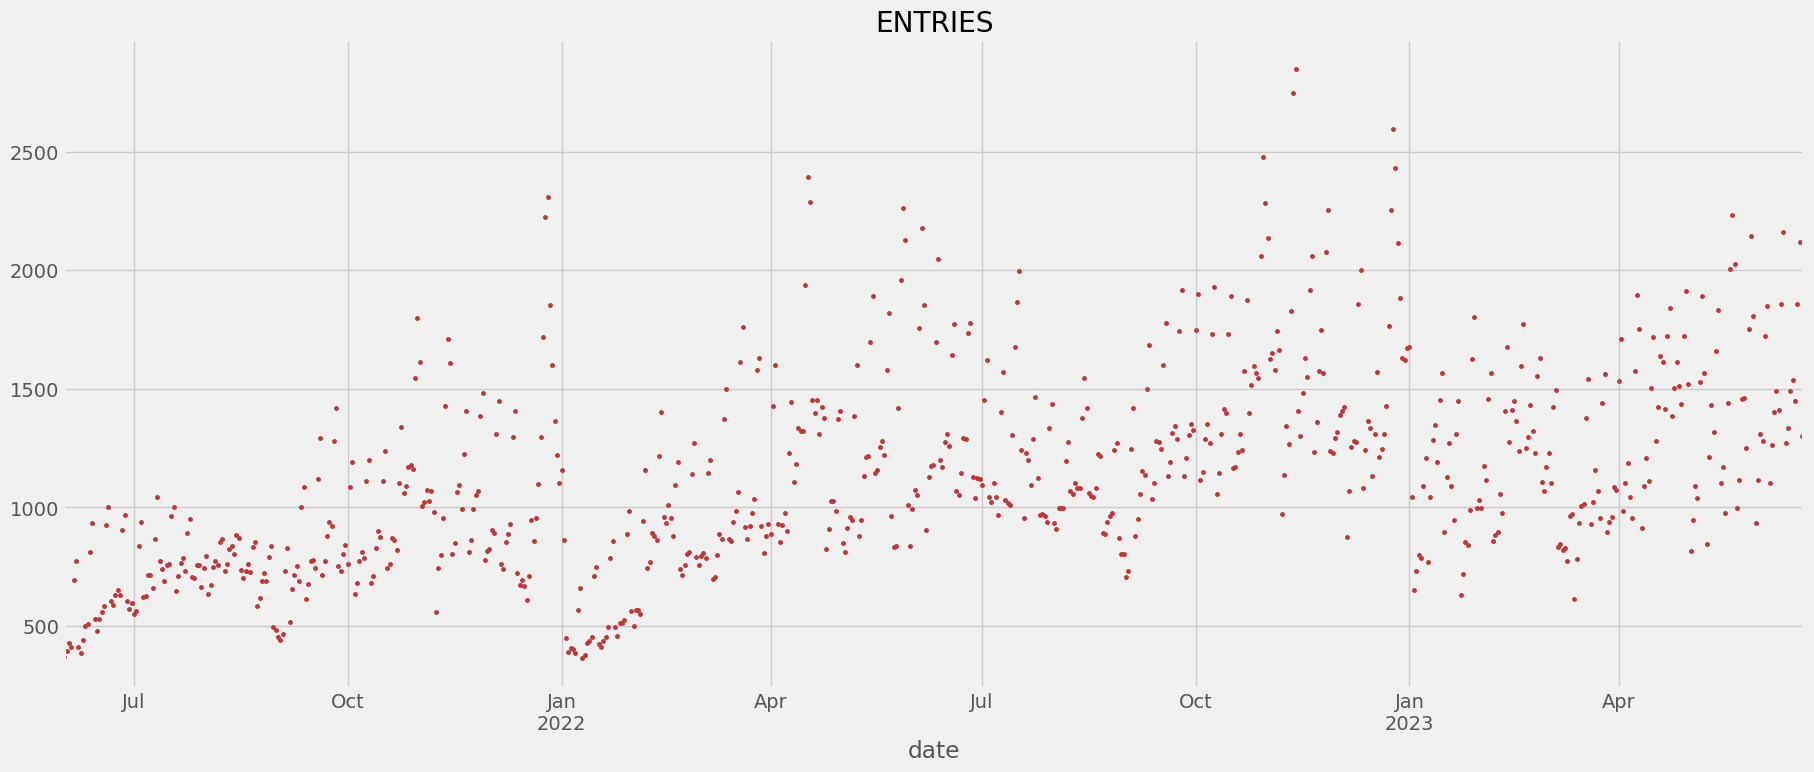

In [4]:
color_palette = sns.color_palette('RdBu')
df['nb_cars'].plot(style='.', 
        figsize=(20, 8), 
        ms=5, 
        color=color_palette[0], 
        title="ENTRIES")

In [5]:
# CODE FIND ON KAGGLE TO USE IF WE WANT FEATURE CREATION
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

# X, y = create_features("DATAFRAME", label='MY_DATAFRAME')
# features_and_target = pd.concat([X, y], axis=1)

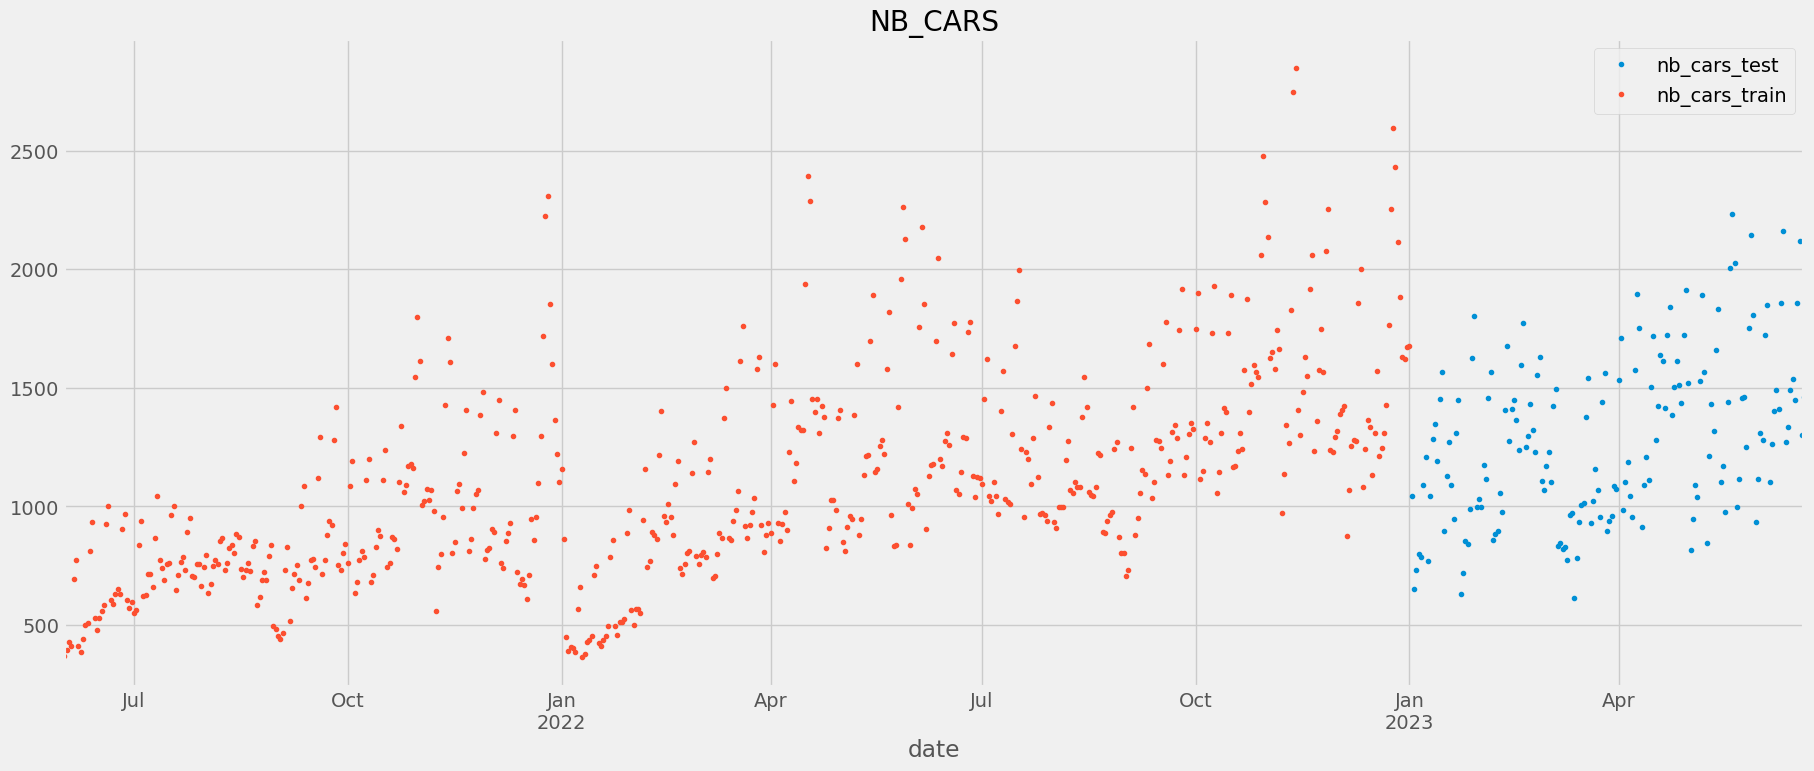

In [6]:
# TRAIN / TEST SPLIT

# Let's keep 2023 for the test split
split_date = '2023-01-01'
df_train = df.loc[df.index <= split_date].copy() 
df_test = df.loc[df.index > split_date].copy() 

# Rename 'nb_cars' in df_train and df_test
df_train = df_train.rename(columns={
    'nb_cars':'nb_cars_train', 
    'nb_cars_cxl': 'nb_cars_cxl_train',
    'nb_bookings': 'nb_bookings_train',
    'nb_bookings_cxl': 'nb_bookings_cxl_train'
    })
df_test = df_test.rename(columns={'nb_cars': 'nb_cars_test'})

# Join the two df
#merged_df = df_test.join(df_train, how='outer')
merged_df = df_test.merge(df_train, how='outer', left_index=True, right_index=True)

merged_df.plot(y=['nb_cars_test', 'nb_cars_train'], figsize=(20, 8), style='.', title="NB_CARS")

# Let's see the result
plt.show()

In [7]:
merged_df

,nb_cars_test,nb_cars_cxl,nb_bookings,nb_bookings_cxl,nb_cars_train,nb_cars_cxl_train,nb_bookings_train,nb_bookings_cxl_train
date,,,,,,,,
2021-06-01,NaN,NaN,NaN,NaN,368.0,30.0,172.0,12.0
2021-06-02,NaN,NaN,NaN,NaN,395.0,34.0,169.0,4.0
2021-06-03,NaN,NaN,NaN,NaN,428.0,26.0,170.0,13.0
2021-06-04,NaN,NaN,NaN,NaN,412.0,25.0,424.0,30.0
2021-06-05,NaN,NaN,NaN,NaN,695.0,49.0,187.0,16.0
...,...,...,...,...,...,...,...,...
2023-06-16,1450.0,99.0,1070.0,58.0,NaN,NaN,NaN,NaN
2023-06-17,1858.0,112.0,583.0,37.0,NaN,NaN,NaN,NaN
2023-06-18,2119.0,121.0,268.0,12.0,NaN,NaN,NaN,NaN


In [8]:
# SIMPLE PROPHET MODEL
df_train_prophet = df_train.reset_index() \
    .rename(columns={'date':'ds',
                     'nb_cars_train':'y'})

In [9]:
df_train_prophet.head()

,ds,y,nb_cars_cxl_train,nb_bookings_train,nb_bookings_cxl_train
0,2021-06-01,368,30,172,12
1,2021-06-02,395,34,169,4
2,2021-06-03,428,26,170,13
3,2021-06-04,412,25,424,30
4,2021-06-05,695,49,187,16


In [10]:
model = Prophet()
model.fit(df_train_prophet)

19:03:54 - cmdstanpy - INFO - Chain [1] start processing
19:03:54 - cmdstanpy - INFO - Chain [1] done processing
19:03:54 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 9 Unknown error: -9
Optimization terminated abnormally. Falling back to Newton.
19:03:54 - cmdstanpy - INFO - Chain [1] start processing
19:03:54 - cmdstanpy - INFO - Chain [1] done processing
19:03:54 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 9 Unknown error: -9


RuntimeError: Error during optimization! Command '/Users/lefebvreremy/miniconda3/envs/env-prophet/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin random seed=34368 data file=/var/folders/w2/rd9l1r6n2dd4w41zgkcssjv40000gn/T/tmp5aiklx_n/ffva3f3c.json init=/var/folders/w2/rd9l1r6n2dd4w41zgkcssjv40000gn/T/tmp5aiklx_n/w8f1teo_.json output file=/var/folders/w2/rd9l1r6n2dd4w41zgkcssjv40000gn/T/tmp5aiklx_n/prophet_modelb7idausv/prophet_model-20230626190354.csv method=optimize algorithm=newton iter=10000' failed: 

In [ ]:
install_name_tool -add_rpath @executable_path/cmdstan-2.26.1/stan/lib/stan_math/lib/tbb /Users/lefebvreremy/miniconda3/envs/env-carpark/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin